In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import csv

hist = []
files = ['../excel/dados_historicos_alunos_de_EngComputacaoCuritiba formados.csv',
         '../excel/dados_historicos_alunos_de_EngComputacaoCuritiba regulares.csv',
         #'../excel/dados_historicos_alunos_de_EngComputacaoCuritiba trancados.csv',
         #'../excel/dados_historicos_alunos_de_EngComputacaoCuritiba desistentes mudancas curso.csv'
         ]

# preenche as listas iniciais
for file in files:
    print(file)
    with open(file, 'r') as csvfile:   
        reader = csv.DictReader(csvfile, delimiter=';')
        for row in reader:
            hist.append(row)
print(len(hist))

../excel/dados_historicos_alunos_de_EngComputacaoCuritiba formados.csv
../excel/dados_historicos_alunos_de_EngComputacaoCuritiba regulares.csv
50026


In [2]:
# função para verificar se um aluno teve seu ingresso antes ou depois de 2014
def beforeClasses(date):
    year = date.split('/')[2]
    if (int(year) < 14):
        return True
    return False

In [3]:
# Remove todos os alunos que ingressaram antes de 2014 
for i in range(len(hist)):
    if (i == len(hist)):
        break
    if (beforeClasses(hist[i]['INGRESSO'].split(" ")[0])):
        hist.pop(i)
        i = 0

# Remove todos dados de reprovações (matérias repetidas)
for i in range(len(hist)):
    for j in range(i, len(hist)):
        if (j == len(hist)):
            break
        if (hist[i]["ID_ANONIMO"] != hist[j]["ID_ANONIMO"]):
            break
        if (j < len(hist) and (i != j and (hist[i]["ID_ANONIMO"] == hist[j]["ID_ANONIMO"] and hist[i]["CODIGO"] == hist[j]["CODIGO"]))):
            hist.pop(j)
            j -= 5
len(hist)

# TODO: caso o aluno tenha reprovado em uma matéria, deve ser removido também. 
# Uma reprovação não conta para o sistema de recomendação

33816

In [4]:
G = nx.Graph()

# Adiciona todos os nós, que são os alunos
# Sem colocar nenhum aluno pré-2014
for line in hist:
    if (not beforeClasses(line['INGRESSO'].split(" ")[0])):
        if not G.has_node(line["ID_ANONIMO"]):
            G.add_node(line["ID_ANONIMO"])
G.nodes()

NodeView(('90729', '113853', '118844', '123664', '123676', '123677', '123686', '123688', '123736', '129034', '131006', '131014', '136341', '136730', '136731', '136736', '145077', '150873', '150878', '150887', '150892', '151217', '156158', '158257', '159067', '160836', '160839', '160852', '160855', '161216', '161223', '161226', '161228', '165431', '165432', '165685', '165892', '165894', '165895', '166050', '169043', '171740', '171745', '171746', '171749', '171750', '171751', '171754', '171755', '172044', '172045', '172046', '172207', '172208', '172248', '172307', '172974', '175962', '179385', '179393', '179397', '179408', '179624', '179652', '179819', '179822', '179823', '179944', '180984', '182856', '182913', '183413', '183414', '186021', '186024', '186036', '189048', '190493', '190494', '190495', '190499', '190508', '190615', '191284', '198372', '198543', '202261', '11357', '104342', '104372', '104768', '110307', '113861', '118817', '123657', '123682', '124800', '126813', '130359', '1

In [5]:
print(G.number_of_nodes())

484


In [6]:
# Verifica quais são as matérias obrigatórias, que não serão levadas em conta
optional = []
with open('../texts/optativas.txt', 'r') as f:   
    lines = f.readlines()
    for l in lines:
        optional.append(l.split(" ")[0])

print(optional)

['CSH30', 'CSV30', 'CSH42', 'CSI53', 'CSV40', 'CSR44', 'CSR41', 'CSR42', 'MA70C', 'CSB51', 'ED70T', 'CSB41', 'CSI41', 'DI84D', 'CSV45', 'CSR43', 'CSM44', 'CSM41', 'CSM43', 'ES70J', 'ES70B', 'CSM40', 'CSB53', 'ES70N', 'GE70F', 'CSA44', 'CSB54', 'CSH44', 'EEY41', 'ED70U', 'CSH43', 'CSE40', 'CSM30', 'CSI56', 'CSA45', 'FI70B', 'FI70D', 'CSA42', 'EL64B', 'CSV52', 'CSB52', 'CSD41', 'FI70A', 'CSD40', 'CSR53', 'CSG42', 'CSI58', 'CSI57', 'CSG48', 'CSV41', 'CSI51', 'CSW45', 'CSE43', 'CSI55', 'FCH7HB', 'CSR47', 'EEY44', 'CSH45', 'CSA41', 'EEC41', 'EL6CB', 'EEY43', 'CSR48', 'EEY42', 'EL6AE', 'CSH41', 'CSD52', 'EEY51', 'EEL51', 'CSI54', 'CSA43', 'CSW47', 'CSI31', 'IF6BV', 'CSR45', 'CSG44', 'FI70E', 'EL75H']


In [7]:
# classe estudante para adicionar as trilhas
class estudante:
    def __init__(self, id_anonimo, status, ano_ingresso):
        self.id_anonimo = id_anonimo
        self.status = status
        self.ano_ingresso = ano_ingresso
        self.trilhas = []
        self.disciplinas = []

    def add_disciplina(self, d):
        self.disciplinas.append(d)
    
    def add_trilha(self, t):
        self.trilhas.append(t)


trilhas = []
with open("../texts/trilhas.txt") as f:
    for line in f.readlines():
        trilhas.append(line.split("\n")[0].split(";"))

In [8]:
estudantes = []
# adiciona todos os estudantes na lista
for i in range(len(hist)):
    # o estudante deve estar no grafo
    if G.has_node(hist[i]["ID_ANONIMO"]):
        # verifica se o estudante já está na lista de estudantes, se não cria um novo
        e = next((x for x in estudantes if x.id_anonimo == hist[i]["ID_ANONIMO"]), None)
        if e == None:
            e = estudante(hist[i]["ID_ANONIMO"], hist[i]["SITUACAOALUNO"], hist[i]["INGRESSO"].split("/")[2])
            estudantes.append(e)
for e in estudantes:
    print(e.id_anonimo, e.disciplinas)
            

90729 []
113853 []
118844 []
123664 []
123676 []
123677 []
123686 []
123688 []
123736 []
129034 []
131006 []
131014 []
136341 []
136730 []
136731 []
136736 []
145077 []
150873 []
150878 []
150887 []
150892 []
151217 []
156158 []
158257 []
159067 []
160836 []
160839 []
160852 []
160855 []
161216 []
161223 []
161226 []
161228 []
165431 []
165432 []
165685 []
165892 []
165894 []
165895 []
166050 []
169043 []
171740 []
171745 []
171746 []
171749 []
171750 []
171751 []
171754 []
171755 []
172044 []
172045 []
172046 []
172207 []
172208 []
172248 []
172307 []
172974 []
175962 []
179385 []
179393 []
179397 []
179408 []
179624 []
179652 []
179819 []
179822 []
179823 []
179944 []
180984 []
182856 []
182913 []
183413 []
183414 []
186021 []
186024 []
186036 []
189048 []
190493 []
190494 []
190495 []
190499 []
190508 []
190615 []
191284 []
198372 []
198543 []
202261 []
11357 []
104342 []
104372 []
104768 []
110307 []
113861 []
118817 []
123657 []
123682 []
124800 []
126813 []
130359 []
136002 []
13

In [9]:
# adiciona todos os estudantes na lista
for i in range(len(hist)):
    for j in range(len(estudantes)):
        if (hist[i]["ID_ANONIMO"] == estudantes[j].id_anonimo):
            if (hist[i]["CODIGO"] in optional):
                estudantes[j].add_disciplina(hist[i]["CODIGO"])
for e in estudantes:
    print(e.id_anonimo, e.disciplinas)

90729 ['CSM41', 'CSH43', 'EL64B', 'MA70C', 'FI70D', 'FI70A', 'ES70N', 'GE70F', 'CSH42', 'CSM43', 'CSH30', 'EL6AE']
113853 ['CSH30', 'ES70N', 'GE70F', 'CSI58', 'CSR53', 'CSR41', 'CSI54', 'CSW47', 'FI70D', 'FI70A']
118844 ['CSV30', 'CSH30', 'CSM41', 'CSH42', 'CSM40']
123664 ['CSH30', 'CSH42', 'CSD41', 'FI70A', 'MA70C', 'ES70N']
123676 ['CSV45', 'CSV30', 'CSM30', 'CSE40', 'EEY41', 'CSH30']
123677 ['FI70A', 'ES70N', 'CSH30', 'CSR43', 'CSV40', 'CSV45', 'CSV30', 'CSR44']
123686 ['CSH30', 'CSI53', 'CSH42', 'CSI41', 'CSV40', 'CSV30', 'FI70A', 'ES70N']
123688 ['CSA44', 'CSA45', 'CSH30', 'CSB41', 'CSI56', 'CSR42', 'CSA42', 'CSI41', 'CSR53', 'CSR41', 'CSV40', 'CSV30']
123736 ['FI70D', 'FI70A', 'CSD52', 'CSI41', 'CSH30', 'ES70N', 'MA70C']
129034 ['CSR45', 'CSD40', 'ES70J', 'ES70N', 'GE70F', 'ES70B']
131006 ['EEY41', 'CSA44', 'CSV45', 'CSV30', 'CSH30', 'EEY42']
131014 ['CSH30', 'DI84D', 'CSV40', 'CSM44', 'CSA44', 'CSV30']
136341 ['FI70A', 'ES70N', 'CSV45', 'CSV30', 'CSH41', 'CSH30']
136730 ['CSR44'

In [10]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

# Adiciona as trilhas de cada estudante
for e in estudantes:
    for t in trilhas:
        if (len(intersection(e.disciplinas, t)) >= 2):
            e.add_trilha(t[0])
for e in estudantes:
    print(e.id_anonimo, e.trilhas)


90729 ['Fisica', 'IHC', 'Desenvolvimento Baseado em Plataformas Programacao', 'Optativas Isoladas']
113853 ['Redes De Computadores', 'Fisica', 'Optativas Isoladas']
118844 ['IHC', 'Desenvolvimento Baseado em Plataformas Programacao']
123664 ['Otimizacao, Modelos Analiticos e de Simulacao', 'IHC']
123676 ['Processamento Grafico', 'Engenharia De Software']
123677 ['Processamento Grafico', 'Redes De Computadores']
123686 ['Processamento Grafico', 'Sistemas Inteligentes', 'IHC']
123688 ['Processamento Grafico', 'Sistemas Inteligentes', 'Algoritmos E Complexidade', 'Redes De Computadores']
123736 ['Otimizacao, Modelos Analiticos e de Simulacao', 'Fisica']
129034 ['Optativas Isoladas']
131006 ['Processamento Grafico', 'Engenharia Biomedica']
131014 ['Processamento Grafico', 'Desenvolvimento Baseado em Plataformas Programacao']
136341 ['Processamento Grafico', 'IHC']
136730 ['Redes De Computadores', 'IHC']
136731 ['Redes De Computadores', 'Otimizacao, Modelos Analiticos e de Simulacao']
13673

In [11]:
# Adiciona as arestas
for i in range(len(estudantes)):
    for j in range(i, len(estudantes)):
        w = len(intersection(estudantes[i].trilhas, estudantes[j].trilhas))
        if (w > 0):
            G.add_edge(estudantes[i].id_anonimo, estudantes[j].id_anonimo, weight = w)

In [12]:
# Remover as arestas com peso pequeno
edges_remove = []
for u, v, a in G.edges(data=True):
    if a["weight"] < 0:
        edges_remove.append([u, v])
G.remove_edges_from(edges_remove)

In [13]:
print(G.number_of_edges())

4641


In [14]:
# ordena os vértices por grau, para verificar os alunos com maior n de matérias em comum
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
remove = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(remove)
G.number_of_nodes()

147

In [15]:
with open('node_degree_all.txt', 'w') as f:
    for degree in degrees:
        f.write(str(degree) + "\n")

In [16]:
# Escreve o arquivo gexf para visualização de grafos
nx.write_gexf(G, "grafo_caminho.gexf")

In [17]:
# ordena as arestas por peso, buscando assim quais os estudantes mais relacionadas
edges = sorted(G.edges(data=True), key=lambda edge: edge[2].get('weight', 1))
with open('edge_weights.txt', 'w') as f1:
    for edge in edges:
        f1.write(str(edge) + "\n")


In [18]:
import leidenalg as la
import igraph as ig
# Separa o grafo em comunidades
# O alg usado para isso é o Leinden, com a biblioteca LeidenAlg
# para isso, é preciso transformar o grafo do networkX para Igraph
H = ig.Graph.from_networkx(G)
H.is_weighted()

True

In [19]:
ws = []
for e in H.es():
  ws.append(e['weight'])

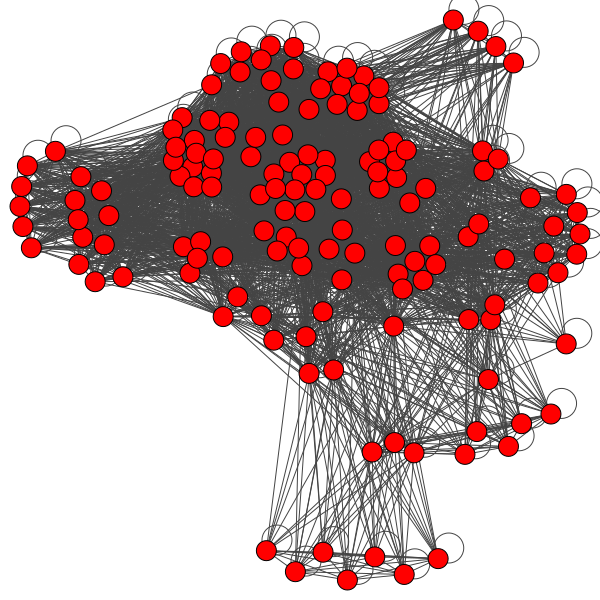

In [20]:
ig.plot(H)

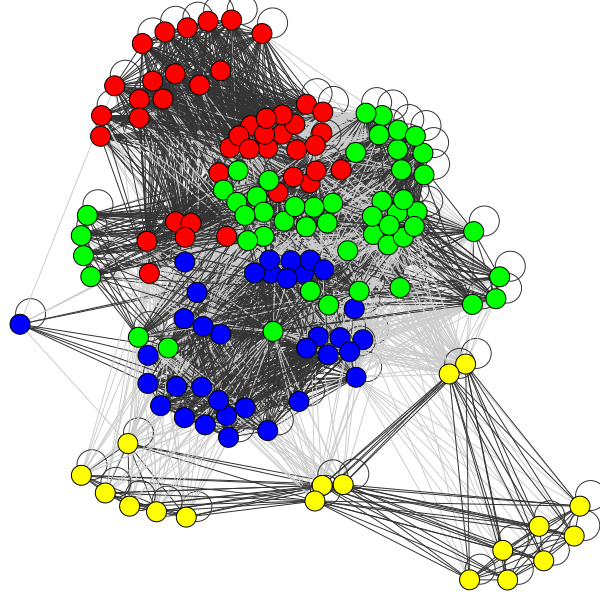

In [21]:
# Agora roda a partição
# Todos os algoritmos utilizados possuem a opção de utilizar arestas com ou sem peso
#   no nosso caso, sempre serão usadas arestas com peso

# Algoritmo de Leiden 
#partition = la.find_partition(H, la.ModularityVertexPartition, weights=H.es()[:]["weight"], n_iterations=50)

# Algoritmo de Infomap Martin Rosvall e Carl T. Bergstrom
# Este algoritmo também aceita vértices com peso, talvez possa ser interessante utilizando algum atributo para os alunos
# Não devide em nenhuma comunidade :(
#partition = H.community_infomap(edge_weights='weight')

# Algoritmo de propagação de labels (??) de Raghavan
# Não divide em nenhuma comunidade
#partition = H.community_label_propagation(weights='weight')

# Algoritmo de Newman
# Em média, divide em 2 comunidades.
# Engraçado que sem colocar pesos ele separa em 3
#partition = H.community_leading_eigenvector(weights='weight')

# Algoritmo de Leiden implementado no Igraph
# Separou em muitas comunidades wtf
# Verificar depois 
partition = H.community_leiden(weights='weight', objective_function='modularity')

# Algoritmo de multilevel de Blondel
# separa de 3 a 4 comunidades
#partition = H.community_multilevel(weights='weight')

ig.plot(partition)



In [22]:
comunidades = []
for com in enumerate(partition.membership):
    if (len(comunidades) <= com[1]):
        comunidades.append([])
    comunidades[com[1]].append(H.vs()[com[0]]["_nx_name"])

import pandas as pd
dados = []
for file in files:
    with open(file, 'r') as csvfile:   
        dados.append(pd.read_csv(csvfile, delimiter=';'))

trilhas = []
with open("../texts/trilhas.txt") as f:
    for line in f.readlines():
        trilhas.append(line.split("\n")[0].split(";"))

print(comunidades)


[['90729', '113853', '123736', '129034', '150878', '150887', '151217', '158257', '159067', '160836', '160839', '160852', '160855', '161223', '161226', '165431', '165432', '165685', '165894', '166050', '171745', '171749', '172045', '172207', '172974', '179944', '11357', '110307', '118817', '126813', '147820', '160841', '160846', '177170', '190684', '193634', '198761', '212903', '250128', '250152', '251697', '253829', '253830'], ['118844', '123664', '136730', '136731', '150892', '156158', '161216', '161228', '165892', '165895', '169043', '171740', '171754', '172044', '172046', '172248', '172307', '175962', '179385', '179393', '179397', '179408', '179823', '180984', '182913', '183413', '190493', '190494', '190499', '191284', '198372', '198543', '104372', '136716', '136720', '136734', '157060', '160837', '161257', '169044', '171652', '172042', '175469', '177422', '177427', '179389', '179405', '179821', '186026', '186031', '202688'], ['123676', '123677', '123686', '123688', '131006', '13101

In [23]:
dados = pd.concat(dados)

In [24]:
dados_filtrados = dados[dados.CODIGO.apply(lambda a: a in optional)]
dados_filtrados = dados_filtrados[[int(x[3].split('/')[2].split(' ')[0]) >= 14 for x in dados_filtrados.values]]
dados_filtrados = dados_filtrados[[float(str(x[7]).replace(',','.')) >= 6 for x in dados_filtrados.values]]
dados_filtrados = dados_filtrados[[x[4] != 'ES70N' or x[5] > 2017 for x in dados_filtrados.values]]
dados_filtrados = dados_filtrados[[x[4] != 'FI70D' or x[5] > 2017 for x in dados_filtrados.values]]
dados_filtrados = dados_filtrados[[x[4] != 'FI70A' or x[5] > 2017 for x in dados_filtrados.values]]
dados_filtrados = dados_filtrados[[x[4] != 'GE70F' or x[5] > 2017 for x in dados_filtrados.values]]
#dados_filtrados

from collections import Counter

# Pega as disciplinas mais populares em cada comunidade
#for idx, comunidade in enumerate(disciplinas_comunidades):
#    print("Comunidade " + str(idx) + ": " + str(Counter(comunidade.CODIGO).most_common()))
i = 0
for comunidade in comunidades:
    if (len(comunidade) > 1):
        print("Comunidade " + str(i) + ":")
        em_trilha = []
        for trilha in trilhas:
            est_in_trilha = 0
            for e_id in range(len(comunidade)):
                for estudante in estudantes:
                    if (estudante.id_anonimo == comunidade[e_id]):
                        if (trilha[0] in estudante.trilhas):
                            est_in_trilha += 1
            if (est_in_trilha > 0):
                print("Trilha " + trilha[0] + ": " + str(est_in_trilha))
        print("\n==================================================================================================================================================================\n")
    i += 1

Comunidade 0:
Trilha Processamento Grafico: 3
Trilha Sistemas Inteligentes: 1
Trilha Redes De Computadores: 5
Trilha Engenharia De Software: 2
Trilha Otimizacao, Modelos Analiticos e de Simulacao: 4
Trilha Fisica: 37
Trilha Banco De Dados: 3
Trilha IHC: 17
Trilha Desenvolvimento Baseado em Plataformas Programacao: 1
Trilha Optativas Isoladas: 32


Comunidade 1:
Trilha Sistemas Inteligentes: 1
Trilha Algoritmos E Complexidade: 1
Trilha Redes De Computadores: 22
Trilha Engenharia De Software: 1
Trilha Otimizacao, Modelos Analiticos e de Simulacao: 3
Trilha Fisica: 1
Trilha Banco De Dados: 4
Trilha IHC: 36
Trilha Engenharia Biomedica: 3
Trilha Desenvolvimento Baseado em Plataformas Programacao: 24
Trilha Optativas Isoladas: 3


Comunidade 2:
Trilha Processamento Grafico: 34
Trilha Sistemas Inteligentes: 7
Trilha Algoritmos E Complexidade: 2
Trilha Redes De Computadores: 7
Trilha Engenharia De Software: 2
Trilha Banco De Dados: 4
Trilha IHC: 9
Trilha Engenharia Biomedica: 1
Trilha Desenvol

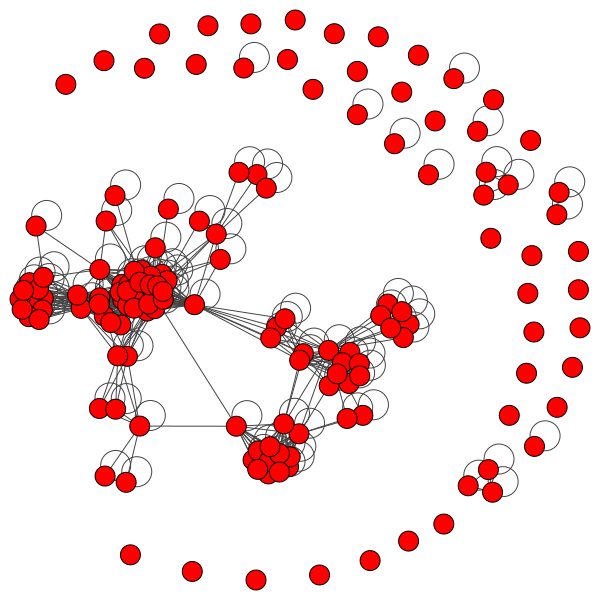

In [25]:
# Utilizando o mesmo grafo H, passa pelas arestas e procura os cliques
edges_to_remove = []
# remoção de arestas de peso 1
H.es.select(weight=1).delete()
#H.es.select(weight=2).delete()

ig.plot(H)

[(75, 11, 95), (129, 82, 124), (3, 42, 119), (78, 97, 103), (19, 24, 43), (115, 7, 126, 32), (81, 43, 122, 79), (8, 28, 89, 42), (43, 25, 56, 37, 15), (43, 25, 56, 37, 24), (97, 58, 94, 80, 68), (23, 1, 100, 91, 52), (64, 6, 72, 56, 53, 48, 7), (7, 127, 76, 74, 63, 17, 5), (7, 32, 45), (7, 32, 47), (7, 6, 53, 45), (7, 6, 53, 47), (80, 0, 68, 20), (80, 0, 68, 100, 91, 52, 1), (110, 6, 108, 65, 62, 53, 46, 45, 12), (13, 32, 136, 114, 71, 70, 60, 59, 54, 51, 47, 41, 36), (61, 0, 119, 112, 106, 85, 84, 83, 57, 38, 29, 22, 20, 2), (119, 0, 38, 42), (38, 0, 99, 50, 44, 39, 35, 34, 30, 27, 26, 24, 21, 20), (38, 0, 99, 50, 44, 39, 35, 34, 30, 27, 26, 24, 21, 42, 33), (42, 0, 99, 89, 50, 44, 39, 35, 34, 30, 28, 27, 26, 24, 21), (31, 0, 128, 99, 50, 44, 39, 35, 34, 30, 27, 26, 24, 21, 20, 18), (35, 0, 144, 131, 125, 111, 100, 99, 91, 89, 87, 56, 52, 50, 44, 39, 37, 34, 30, 28, 27, 26, 25, 24, 21, 1)]


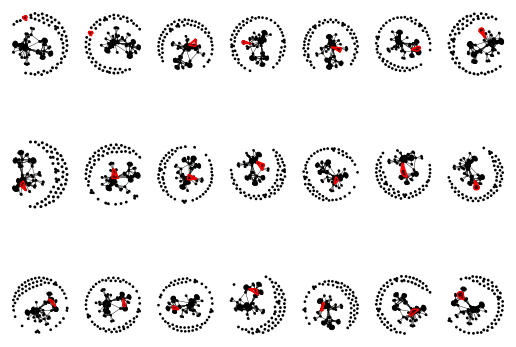

In [26]:
cliques = H.maximal_cliques(min=3)
print(cliques)

fig, axs = plt.subplots(3, 7)
axs = axs.ravel()
for clique, ax in zip(cliques, axs):
    # Color vertices yellow/red based on whether they are in this clique
    H.vs['color'] = 'yellow'
    H.vs[clique]['color'] = 'red'

    # Color edges black/red based on whether they are in this clique
    clique_edges = H.es.select(_within=clique)
    H.es['color'] = 'black'
    clique_edges['color'] = 'red'
    # also increase thickness of clique edges
    H.es['width'] = 0.3
    clique_edges['width'] = 1

    ig.plot(
        ig.VertexCover(H, [clique]),
        mark_groups=True,
        palette=ig.RainbowPalette(),
        vertex_size=0.5,
        target=ax,
    )
plt.axis('off')
plt.show()


In [27]:
# análise dos cliques
i = 0
for clique in cliques:
    print("Clique " + str(i))
    for c in clique:
        for e in estudantes:
            if e.id_anonimo == H.vs[c]['_nx_name']:
                print("ID: " + e.id_anonimo + "; Trilhas: " + str(e.trilhas))
    i += 1
    print("================================================================================")

Clique 0
ID: 186036; Trilhas: ['Processamento Grafico', 'Desenvolvimento Baseado em Plataformas Programacao']
ID: 131014; Trilhas: ['Processamento Grafico', 'Desenvolvimento Baseado em Plataformas Programacao']
ID: 137191; Trilhas: ['Processamento Grafico', 'Desenvolvimento Baseado em Plataformas Programacao']
Clique 1
ID: 193637; Trilhas: ['Algoritmos E Complexidade', 'Banco De Dados']
ID: 190615; Trilhas: ['Algoritmos E Complexidade', 'Banco De Dados']
ID: 190502; Trilhas: ['Algoritmos E Complexidade', 'Banco De Dados']
Clique 2
ID: 123664; Trilhas: ['Otimizacao, Modelos Analiticos e de Simulacao', 'IHC']
ID: 171745; Trilhas: ['Otimizacao, Modelos Analiticos e de Simulacao', 'Fisica', 'IHC']
ID: 186026; Trilhas: ['Otimizacao, Modelos Analiticos e de Simulacao', 'IHC', 'Desenvolvimento Baseado em Plataformas Programacao']
Clique 3
ID: 190494; Trilhas: ['Banco De Dados', 'Desenvolvimento Baseado em Plataformas Programacao']
ID: 157060; Trilhas: ['Redes De Computadores', 'Banco De Dados